In [1]:
#from 7/15, 4:04 PM slack message from POC, instructions
#  1   pick your favorite frequency index
#  2   make joint fits for the four (atten, pol) flight pairs [342,343], [352,353], [344,347], [349,351]. No trimming.
#  3   do 2D interpolation for the same datasets
#  4   make a table of (x0,y0),  (sigma-x, sigma-y), with +/- uncertainties for each (atten, pol) condition
#  5   make contour plots with (x0,y0) and CoM triangles like before, for each dish/atten/pol, i.e. 16 plots.

In [1]:
#Requisite modules
import pickle
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interp
import scipy.optimize as opt
import scipy.ndimage
from astropy.table import Table, Column

In [2]:
#reading in allFLYs data
with open('../Data/allFLYs.pkl', 'rb') as pickle_file:
    allFLYs = pickle.load(pickle_file, encoding = 'latin1')

In [3]:
#defining gaussian fit
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, offset):
    (x, y) = xdata_tuple                                                        
    xo = float(xo)                                                              
    yo = float(yo)                                                              
    g = offset + amplitude * np.exp(-(((x-xo)**2)/(2*sigma_x**2) + ((y-yo)**2)/(2*sigma_y**2)))
    return g.ravel()

In [4]:
#defining a function that gives the range of a dataset
#for creating boundaries
def span(data):
    return (max(data)-min(data))

In [5]:
#gathering all the data together that will be used for the code

#pre-counting
length = 0
for i in range(len(allFLYs)):
    length += len(allFLYs[i]['x'])

#prealloacting arrays
dish1signal, dish2signal, dish3signal, dish4signal = np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length)),np.zeros((256, length))
dish1_thetax, dish2_thetax, dish3_thetax, dish4_thetax = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)
dish1_thetay, dish2_thetay, dish3_thetay, dish4_thetay = np.zeros(length),np.zeros(length),np.zeros(length),np.zeros(length)

countermin = 0
countermax = 0
for i in range(len(allFLYs)):
    countermax += len(allFLYs[i]['x'])
    autospectra = np.array(allFLYs[i]['autos'])
    
    #populating location arrays for step 2
    dish1_thetax[countermin:countermax] = allFLYs[i]['thetaX'][0]
    dish2_thetax[countermin:countermax] = allFLYs[i]['thetaX'][1]
    dish3_thetax[countermin:countermax] = allFLYs[i]['thetaX'][2]
    dish4_thetax[countermin:countermax] = allFLYs[i]['thetaX'][3]
    
    dish1_thetay[countermin:countermax] = allFLYs[i]['thetaY'][0]
    dish2_thetay[countermin:countermax] = allFLYs[i]['thetaY'][1]
    dish3_thetay[countermin:countermax] = allFLYs[i]['thetaY'][2]
    dish4_thetay[countermin:countermax] = allFLYs[i]['thetaY'][3]
    
    #populating signal arrays
    for j in range(0, 256):
        dish1signal[j][countermin:countermax] = autospectra[0][:,j]
        dish2signal[j][countermin:countermax] = autospectra[1][:,j]
        dish3signal[j][countermin:countermax] = autospectra[2][:,j]
        dish4signal[j][countermin:countermax] = autospectra[3][:,j]
        
    countermin += len(allFLYs[i]['x'])    

#start by gathering data to fit
#thetaX, thetaY

#creating starting and stopping points for the flight pairs
startpair1 = len(allFLYs[0]['x'])
endpair1 = startpair1 + len(allFLYs[1]['x']) + len(allFLYs[2]['x'])
endpair2 = endpair1 + len(allFLYs[3]['x']) + len(allFLYs[4]['x'])
endpair3 = endpair2 + len(allFLYs[5]['x']) + len(allFLYs[6]['x'])
endpair4 = endpair3 + len(allFLYs[7]['x']) + len(allFLYs[8]['x'])

#x data for [342,343] for all 4 dishes
dish1x_pair1 = dish1_thetax[startpair1:endpair1]
dish2x_pair1 = dish2_thetax[startpair1:endpair1]
dish3x_pair1 = dish3_thetax[startpair1:endpair1]
dish4x_pair1 = dish4_thetax[startpair1:endpair1]
#y data for [342,343] for all 4 dishes
dish1y_pair1 = dish1_thetay[startpair1:endpair1]
dish2y_pair1 = dish2_thetay[startpair1:endpair1]
dish3y_pair1 = dish3_thetay[startpair1:endpair1]
dish4y_pair1 = dish4_thetay[startpair1:endpair1]

#x data for [352,353] for all 4 dishes
dish1x_pair2 = dish1_thetax[endpair1:endpair2]
dish2x_pair2 = dish2_thetax[endpair1:endpair2]
dish3x_pair2 = dish3_thetax[endpair1:endpair2]
dish4x_pair2 = dish4_thetax[endpair1:endpair2]
#y data for [352,353] for all 4 dishes
dish1y_pair2 = dish1_thetay[endpair1:endpair2]
dish2y_pair2 = dish2_thetay[endpair1:endpair2]
dish3y_pair2 = dish3_thetay[endpair1:endpair2]
dish4y_pair2 = dish4_thetay[endpair1:endpair2]

#x data for [344,347] for all 4 dishes
dish1x_pair3 = dish1_thetax[endpair2:endpair3]
dish2x_pair3 = dish2_thetax[endpair2:endpair3]
dish3x_pair3 = dish3_thetax[endpair2:endpair3]
dish4x_pair3 = dish4_thetax[endpair2:endpair3]
#y data for [344,347] for all 4 dishes
dish1y_pair3 = dish1_thetay[endpair2:endpair3]
dish2y_pair3 = dish2_thetay[endpair2:endpair3]
dish3y_pair3 = dish3_thetay[endpair2:endpair3]
dish4y_pair3 = dish4_thetay[endpair2:endpair3]

#x data for [349,351] for all 4 dishes
dish1x_pair4 = dish1_thetax[endpair3:endpair4]
dish2x_pair4 = dish2_thetax[endpair3:endpair4]
dish3x_pair4 = dish3_thetax[endpair3:endpair4]
dish4x_pair4 = dish4_thetax[endpair3:endpair4]
#y data for [349,351] for all 4 dishes
dish1y_pair4 = dish1_thetay[endpair3:endpair4]
dish2y_pair4 = dish2_thetay[endpair3:endpair4]
dish3y_pair4 = dish3_thetay[endpair3:endpair4]
dish4y_pair4 = dish4_thetay[endpair3:endpair4]


yarray = [dish1y_pair1, dish2y_pair1, dish3y_pair1, dish4y_pair1
          , dish1y_pair2, dish2y_pair2, dish3y_pair2, dish4y_pair2
          , dish1y_pair3, dish2y_pair3, dish3y_pair3, dish4y_pair3
          , dish1y_pair4, dish2y_pair4, dish3y_pair4, dish4y_pair4]

xarray = [dish1x_pair1, dish2x_pair1, dish3x_pair1, dish4x_pair1
          , dish1x_pair2, dish2x_pair2, dish3x_pair2, dish4x_pair2
          , dish1x_pair3, dish2x_pair3, dish3x_pair3, dish4x_pair3
          , dish1x_pair4, dish2x_pair4, dish3x_pair4, dish4x_pair4]

In [6]:
"""make joint fits for the four (atten, pol) flight pairs [342,343], [352,353], [344,347], [349,351]. No trimming."""

#doing all the prep work in this cell

#Getting signal data using max index from previous cell
#signal data for [342,343] for all 4 dishes
def get_signal_data(index):
    global dish1sig_pair1
    global dish2sig_pair1
    global dish3sig_pair1
    global dish4sig_pair1
    global dish1sig_pair2
    global dish2sig_pair2
    global dish3sig_pair2
    global dish4sig_pair2
    global dish1sig_pair3
    global dish2sig_pair3
    global dish3sig_pair3
    global dish4sig_pair3
    global dish1sig_pair4
    global dish2sig_pair4
    global dish3sig_pair4
    global dish4sig_pair4
    global sigarray
    dish1sig_pair1 = dish1signal[index][startpair1:endpair1]
    dish2sig_pair1 = dish1signal[index][startpair1:endpair1]
    dish3sig_pair1 = dish1signal[index][startpair1:endpair1]
    dish4sig_pair1 = dish1signal[index][startpair1:endpair1]
#signal data for [352,353] for all 4 dishes
    dish1sig_pair2 = dish1signal[index][endpair1:endpair2]
    dish2sig_pair2 = dish1signal[index][endpair1:endpair2]
    dish3sig_pair2 = dish1signal[index][endpair1:endpair2]
    dish4sig_pair2 = dish1signal[index][endpair1:endpair2]
#signal data for [344,347] for all 4 dishes
    dish1sig_pair3 = dish1signal[index][endpair2:endpair3]
    dish2sig_pair3 = dish1signal[index][endpair2:endpair3]
    dish3sig_pair3 = dish1signal[index][endpair2:endpair3]
    dish4sig_pair3 = dish1signal[index][endpair2:endpair3]
#signal data for [349,351] for all 4 dishes
    dish1sig_pair4 = dish1signal[index][endpair3:endpair4]
    dish2sig_pair4 = dish1signal[index][endpair3:endpair4]
    dish3sig_pair4 = dish1signal[index][endpair3:endpair4]
    dish4sig_pair4 = dish1signal[index][endpair3:endpair4]
    
    sigarray = [dish1sig_pair1, dish2sig_pair1, dish3sig_pair1, dish4sig_pair1
                , dish1sig_pair2, dish2sig_pair2, dish3sig_pair2, dish4sig_pair2
                , dish1sig_pair3, dish2sig_pair3, dish3sig_pair3, dish4sig_pair3
                , dish1sig_pair4, dish2sig_pair4, dish3sig_pair4, dish4sig_pair4]


def get_initial_guesses():    
#creating initial guesses for the 16 guassian fits
    xguesses = np.zeros(16)
    yguesses = np.zeros(16)
    
    global guessarray
    guessarray = []
    
    #calculating initial guesses
    for k in range(16):
        if np.abs(xarray[k][np.where(sigarray[k]==max(sigarray[k]))][0])<=0.5:
            xguesses[k] = xarray[k][np.where(sigarray[k]==max(sigarray[k]))][0]
        if np.abs(yarray[k][np.where(sigarray[k]==max(sigarray[k]))][0])<=0.5:
            yguesses[k] = yarray[k][np.where(sigarray[k]==max(sigarray[k]))][0]
        #format is: amplitude, x_mean, y_mean, x_sigma, y_sigma, offset
        #prediction is: max signal, (x,y) of max signal, 0.5 for sigmas from visual inspection, assume zero offset
        guessarray.append((max(sigarray[k]), xguesses[k], yguesses[k], 0.05,0.05,0))
   
    

def get_bounds():
#specifying boundaries
    global bound1_pair1
    global bound2_pair1
    global bound3_pair1
    global bound4_pair1
    global bound1_pair2
    global bound2_pair2
    global bound3_pair2
    global bound4_pair2
    global bound1_pair3
    global bound2_pair3
    global bound3_pair3
    global bound4_pair3
    global bound1_pair4
    global bound2_pair4
    global bound3_pair4
    global bound4_pair4
    #boundaries are: amplitude is unbounded, x y coordinates bounded by their respective mins and maxes
    #                sigmas are unbounded below, bounded above by the range of x and y coordinates
    #                offset is unbounded
    bound1_pair1 = ([-np.inf, min(dish1x_pair1), min(dish1x_pair1), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish1x_pair1), max(dish1y_pair1), span(dish1x_pair1),span(dish1y_pair1), np.inf])
    bound2_pair1 = ([-np.inf, min(dish2x_pair1), min(dish2x_pair1), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish2x_pair1), max(dish2y_pair1), span(dish2x_pair1),span(dish2y_pair1), np.inf])
    bound3_pair1 = ([-np.inf, min(dish3x_pair1), min(dish3x_pair1), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish3x_pair1), max(dish3y_pair1), span(dish3x_pair1),span(dish3y_pair1), np.inf])
    bound4_pair1 = ([-np.inf, min(dish4x_pair1), min(dish4x_pair1), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish4x_pair1), max(dish4y_pair1), span(dish4x_pair1),span(dish4y_pair1), np.inf])

    bound1_pair2 = ([-np.inf, min(dish1x_pair2), min(dish1x_pair2), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish1x_pair2), max(dish1y_pair2), span(dish1x_pair2),span(dish1y_pair2), np.inf])
    bound2_pair2 = ([-np.inf, min(dish2x_pair2), min(dish2x_pair2), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish2x_pair2), max(dish2y_pair2), span(dish2x_pair2),span(dish2y_pair2), np.inf])
    bound3_pair2 = ([-np.inf, min(dish3x_pair2), min(dish3x_pair2), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish3x_pair2), max(dish3y_pair2), span(dish3x_pair2),span(dish3y_pair2), np.inf])
    bound4_pair2 = ([-np.inf, min(dish4x_pair2), min(dish4x_pair2), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish4x_pair2), max(dish4y_pair2), span(dish4x_pair2),span(dish4y_pair2), np.inf])

    bound1_pair3 = ([-np.inf, min(dish1x_pair3), min(dish1x_pair3), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish1x_pair3), max(dish1y_pair3), span(dish1x_pair3),span(dish1y_pair3), np.inf])
    bound2_pair3 = ([-np.inf, min(dish2x_pair3), min(dish2x_pair3), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish2x_pair3), max(dish2y_pair3), span(dish2x_pair3),span(dish2y_pair3), np.inf])
    bound3_pair3 = ([-np.inf, min(dish3x_pair3), min(dish3x_pair3), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish3x_pair3), max(dish3y_pair3), span(dish3x_pair3),span(dish3y_pair3), np.inf])
    bound4_pair3 = ([-np.inf, min(dish4x_pair3), min(dish4x_pair3), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish4x_pair3), max(dish4y_pair3), span(dish4x_pair3),span(dish4y_pair3), np.inf])

    bound1_pair4 = ([-np.inf, min(dish1x_pair4), min(dish1x_pair4), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish1x_pair4), max(dish1y_pair4), span(dish1x_pair4),span(dish1y_pair4), np.inf])
    bound2_pair4 = ([-np.inf, min(dish2x_pair4), min(dish2x_pair4), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish2x_pair4), max(dish2y_pair4), span(dish2x_pair4),span(dish2y_pair4), np.inf])
    bound3_pair4 = ([-np.inf, min(dish3x_pair4), min(dish3x_pair4), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish3x_pair4), max(dish3y_pair4), span(dish3x_pair4),span(dish3y_pair4), np.inf])
    bound4_pair4 = ([-np.inf, min(dish4x_pair4), min(dish4x_pair4), -np.inf, -np.inf, -np.inf]
                    ,[np.inf, max(dish4x_pair4), max(dish4y_pair4), span(dish4x_pair4),span(dish4y_pair4), np.inf])

In [7]:
#calculating gaussian fits
def calculate_gaussians():
    global opt1_pair1
    global opt2_pair1
    global opt3_pair1
    global opt4_pair1
    global opt1_pair2
    global opt2_pair2
    global opt3_pair2
    global opt4_pair2
    global opt1_pair3
    global opt2_pair3
    global opt3_pair3
    global opt4_pair3
    global opt1_pair4
    global opt2_pair4
    global opt3_pair4
    global opt4_pair4
    
    opt1_pair1, cov1_pair1 = opt.curve_fit(twoD_Gaussian, (dish1x_pair1, dish1y_pair1), dish1sig_pair1
                                           ,p0 = guessarray[0], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair1)
    opt2_pair1, cov2_pair1 = opt.curve_fit(twoD_Gaussian, (dish2x_pair1, dish2y_pair1), dish2sig_pair1
                                           ,p0 = guessarray[1], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair1)
    opt3_pair1, cov3_pair1 = opt.curve_fit(twoD_Gaussian, (dish3x_pair1, dish3y_pair1), dish3sig_pair1
                                           ,p0 = guessarray[2], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair1)
    opt4_pair1, cov4_pair1 = opt.curve_fit(twoD_Gaussian, (dish4x_pair1, dish4y_pair1), dish4sig_pair1
                                           ,p0 = guessarray[3], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair1)
    opt1_pair2, cov1_pair2 = opt.curve_fit(twoD_Gaussian, (dish1x_pair2, dish1y_pair2), dish1sig_pair2
                                           ,p0 = guessarray[4], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair2)
    opt2_pair2, cov2_pair2 = opt.curve_fit(twoD_Gaussian, (dish2x_pair2, dish2y_pair2), dish2sig_pair2
                                           ,p0 = guessarray[5], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair2)
    opt3_pair2, cov3_pair2 = opt.curve_fit(twoD_Gaussian, (dish3x_pair2, dish3y_pair2), dish3sig_pair2
                                           ,p0 = guessarray[6], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair2)
    opt4_pair2, cov4_pair2 = opt.curve_fit(twoD_Gaussian, (dish4x_pair2, dish4y_pair2), dish4sig_pair2
                                           ,p0 = guessarray[7], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair2)
    opt1_pair3, cov1_pair3 = opt.curve_fit(twoD_Gaussian, (dish1x_pair3, dish1y_pair3), dish1sig_pair3
                                           ,p0 = guessarray[8], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair3)
    opt2_pair3, cov2_pair3 = opt.curve_fit(twoD_Gaussian, (dish2x_pair3, dish2y_pair3), dish2sig_pair3
                                           ,p0 = guessarray[9], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair3)
    opt3_pair3, cov3_pair3 = opt.curve_fit(twoD_Gaussian, (dish3x_pair3, dish3y_pair3), dish3sig_pair3
                                           ,p0 = guessarray[10], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair3)
    opt4_pair3, cov4_pair3 = opt.curve_fit(twoD_Gaussian, (dish4x_pair3, dish4y_pair3), dish4sig_pair3
                                           ,p0 = guessarray[11], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair3)
    opt1_pair4, cov1_pair4 = opt.curve_fit(twoD_Gaussian, (dish1x_pair4, dish1y_pair4), dish1sig_pair4
                                           ,p0 = guessarray[12], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair4)
    opt2_pair4, cov2_pair4 = opt.curve_fit(twoD_Gaussian, (dish2x_pair4, dish2y_pair4), dish2sig_pair4
                                           ,p0 = guessarray[13], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair4)
    opt3_pair4, cov3_pair4 = opt.curve_fit(twoD_Gaussian, (dish3x_pair4, dish3y_pair4), dish3sig_pair4
                                           ,p0 = guessarray[14], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair4)
    opt4_pair4, cov4_pair4 = opt.curve_fit(twoD_Gaussian, (dish4x_pair4, dish4y_pair4), dish4sig_pair4
                                           ,p0 = guessarray[15], maxfev = 100000, method = 'dogbox'
                                           ,bounds = bound1_pair4)

    
    global err1_pair1
    global err2_pair1
    global err3_pair1
    global err4_pair1
    global err1_pair2
    global err2_pair2
    global err3_pair2
    global err4_pair2
    global err1_pair3
    global err2_pair3
    global err3_pair3
    global err4_pair3
    global err1_pair4
    global err2_pair4
    global err3_pair4
    global err4_pair4
    
    #calculating uncertainties
    err1_pair1 = np.sqrt(np.diag(cov1_pair1))
    err2_pair1 = np.sqrt(np.diag(cov2_pair1))
    err3_pair1 = np.sqrt(np.diag(cov3_pair1))
    err4_pair1 = np.sqrt(np.diag(cov4_pair1))
    err1_pair2 = np.sqrt(np.diag(cov1_pair2))
    err2_pair2 = np.sqrt(np.diag(cov2_pair2))
    err3_pair2 = np.sqrt(np.diag(cov3_pair2))
    err4_pair2 = np.sqrt(np.diag(cov4_pair2))
    err1_pair3 = np.sqrt(np.diag(cov1_pair3))
    err2_pair3 = np.sqrt(np.diag(cov2_pair3))
    err3_pair3 = np.sqrt(np.diag(cov3_pair3))
    err4_pair3 = np.sqrt(np.diag(cov4_pair3))
    err1_pair4 = np.sqrt(np.diag(cov1_pair4))
    err2_pair4 = np.sqrt(np.diag(cov2_pair4))
    err3_pair4 = np.sqrt(np.diag(cov3_pair4))
    err4_pair4 = np.sqrt(np.diag(cov4_pair4))
    
    global gaussarray
    global errarray

    gaussarray = [opt1_pair1, opt2_pair1, opt3_pair1, opt4_pair1
                  , opt1_pair2, opt2_pair2, opt3_pair2, opt4_pair2
                  , opt1_pair3, opt2_pair3, opt3_pair3, opt4_pair3
                  , opt1_pair4, opt2_pair4, opt3_pair4, opt4_pair4]

    errarray = [err1_pair1, err2_pair1, err3_pair1, err4_pair1
                , err1_pair2, err2_pair2, err3_pair2, err4_pair2
                , err1_pair3, err2_pair3, err3_pair3, err4_pair3
                , err1_pair4, err2_pair4, err3_pair4, err4_pair4]

In [8]:
"""do 2D interpolation for the same datasets"""

def calculate_interpolations():
    global xi
    global yi
    global xspace
    global yspace
    xi = np.linspace(-0.2, 0.2, 200)  #interpolations are at a 200x200 resolution
    yi = np.linspace(-0.2, 0.2, 200)
    xspace, yspace = np.meshgrid(xi, yi)

    interp_dish1_pair1 = interp.griddata((dish1x_pair1, dish1y_pair1), dish1sig_pair1, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish1sig_pair1))
    interp_dish2_pair1 = interp.griddata((dish2x_pair1, dish2y_pair1), dish2sig_pair1, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish2sig_pair1))
    interp_dish3_pair1 = interp.griddata((dish3x_pair1, dish3y_pair1), dish3sig_pair1, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish3sig_pair1))
    interp_dish4_pair1 = interp.griddata((dish4x_pair1, dish4y_pair1), dish4sig_pair1, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish4sig_pair1))
    interp_dish1_pair2 = interp.griddata((dish1x_pair2, dish1y_pair2), dish1sig_pair2, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish1sig_pair2))
    interp_dish2_pair2 = interp.griddata((dish2x_pair2, dish2y_pair2), dish2sig_pair2, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish2sig_pair2))
    interp_dish3_pair2 = interp.griddata((dish3x_pair2, dish3y_pair2), dish3sig_pair2, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish3sig_pair2))
    interp_dish4_pair2 = interp.griddata((dish4x_pair2, dish4y_pair2), dish4sig_pair2, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish4sig_pair2))
    interp_dish1_pair3 = interp.griddata((dish1x_pair3, dish1y_pair3), dish1sig_pair3, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish1sig_pair3))
    interp_dish2_pair3 = interp.griddata((dish2x_pair3, dish2y_pair3), dish2sig_pair3, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish2sig_pair3))
    interp_dish3_pair3 = interp.griddata((dish3x_pair3, dish3y_pair3), dish3sig_pair3, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish3sig_pair3))
    interp_dish4_pair3 = interp.griddata((dish4x_pair3, dish4y_pair3), dish4sig_pair3, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish4sig_pair3))
    interp_dish1_pair4 = interp.griddata((dish1x_pair4, dish1y_pair4), dish1sig_pair4, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish1sig_pair4))
    interp_dish2_pair4 = interp.griddata((dish2x_pair4, dish2y_pair4), dish2sig_pair4, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish2sig_pair4))
    interp_dish3_pair4 = interp.griddata((dish3x_pair4, dish3y_pair4), dish3sig_pair4, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish3sig_pair4))
    interp_dish4_pair4 = interp.griddata((dish4x_pair4, dish4y_pair4), dish4sig_pair4, (xi[None,:], yi[:,None])
                                         , method = 'linear', fill_value = min(dish4sig_pair4))

    global interparray
    interparray = [interp_dish1_pair1,interp_dish2_pair1,interp_dish3_pair1,interp_dish4_pair1
                  ,interp_dish1_pair2,interp_dish2_pair2,interp_dish3_pair2,interp_dish4_pair2
                  ,interp_dish1_pair3,interp_dish2_pair3,interp_dish3_pair3,interp_dish4_pair3
                  ,interp_dish1_pair4,interp_dish2_pair4,interp_dish3_pair4,interp_dish4_pair4]

In [9]:
"""Calculating CoM"""

def calculate_CoM():
    #preallocation
    interp_backsub = np.zeros((16,200,200))
    global backgrounds
    backgrounds = np.zeros(16)

    #calculating background levels for each plot
    for i in range(len(backgrounds)):
        signal_out = sigarray[i][np.where(np.sqrt((yarray[i]-gaussarray[i][2])**2 + (xarray[i]-gaussarray[i][1])**2)> 4*gaussarray[i][4])]
        backgrounds[i] = np.sum(signal_out)/len(signal_out)
        if np.isnan(backgrounds[i]):
            backgrounds[i] = min(sigarray[i])

    #performing background subtraction
    for i in range(len(interp_backsub)):
        for j in range(len(interp_backsub[i])):
            for k in range(len(interp_backsub[i][j])):
                interp_backsub[i][j][k] = interparray[i][j][k] - backgrounds[i]
    
    global com
    com = []
    for i in range(len(interp_backsub)):
        com.append(scipy.ndimage.center_of_mass(interp_backsub[i]))  #finding center of mass
        com[i]=((com[i][1]-100)/100*0.2, (com[i][0]-100)/100*0.2)    #converting CoM to radians

In [10]:
"""make a table of (x0,y0),  (sigma-x, sigma-y), with +/- uncertainties for each (atten, pol) condition"""
def make_table():
    global uncert
    uncert = Table(names=('flights', 'dish', 'pol','atten', 'x0', 'y0', 'x0_err', 'y0_err', 'x_sigma', 'y_sigma'
                      , 'x_sigma_err' ,'y_sigma_err')
              , dtype = ['str', 'str', 'str', 'int', 'float', 'float', 'float', 'float', 'float', 'float'
                        , 'float', 'float'])

    rows = np.empty(16, dtype = object)


    rows[0] = ['342, 343', 'N','N-S', 30,opt1_pair1[1], opt1_pair1[2], err1_pair1[1], err1_pair1[2],opt1_pair1[3], opt1_pair1[4], err1_pair1[3], err1_pair1[4]]
    rows[1] = ['342, 343', 'E', 'N-S', 30,opt2_pair1[1], opt2_pair1[2], err2_pair1[1], err2_pair1[2],opt2_pair1[3], opt2_pair1[4], err2_pair1[3], err2_pair1[4]]
    rows[2] = ['342, 343', 'S', 'N-S', 30,opt3_pair1[1], opt3_pair1[2], err3_pair1[1], err3_pair1[2],opt3_pair1[3], opt3_pair1[4], err3_pair1[3], err3_pair1[4]]
    rows[3] = ['342, 343', 'W', 'N-S', 30,opt4_pair1[1], opt4_pair1[2], err4_pair1[1], err4_pair1[2],opt4_pair1[3], opt4_pair1[4], err4_pair1[3], err4_pair1[4]]
    rows[4] = ['352, 353', 'N', 'E-W', 30,opt1_pair2[1], opt1_pair2[2], err1_pair2[1], err1_pair2[2],opt1_pair2[3], opt1_pair2[4], err1_pair2[3], err1_pair2[4]]
    rows[5] = ['352, 353', 'E', 'E-W', 30,opt2_pair2[1], opt2_pair2[2], err2_pair2[1], err2_pair2[2],opt2_pair2[3], opt2_pair2[4], err2_pair2[3], err2_pair2[4]]
    rows[6] = ['352, 353', 'S', 'E-W', 30,opt3_pair2[1], opt3_pair2[2], err3_pair2[1], err3_pair2[2],opt3_pair2[3], opt3_pair2[4], err3_pair2[3], err3_pair2[4]]
    rows[7] = ['352, 353', 'W', 'E-W', 30,opt4_pair2[1], opt4_pair2[2], err4_pair2[1], err4_pair2[2],opt4_pair2[3], opt4_pair2[4], err4_pair2[3], err4_pair2[4]]
    rows[8] = ['344, 347', 'N', 'N-S', 43,opt1_pair3[1], opt1_pair3[2], err1_pair3[1], err1_pair3[2],opt1_pair3[3], opt1_pair3[4], err1_pair3[3], err1_pair3[4]]
    rows[9] = ['344, 347', 'E', 'N-S', 43,opt2_pair3[1], opt3_pair3[2], err2_pair3[1], err2_pair3[2],opt2_pair3[3], opt2_pair3[4], err2_pair3[3], err2_pair3[4]]
    rows[10] = ['344, 347', 'S', 'N-S', 43,opt3_pair3[1], opt3_pair3[2], err3_pair3[1], err3_pair3[2],opt3_pair3[3], opt3_pair3[4], err3_pair3[3], err3_pair3[4]]
    rows[11] = ['344, 347', 'W', 'N-S', 43,opt4_pair3[1], opt4_pair3[2], err4_pair3[1], err4_pair3[2],opt4_pair3[3], opt4_pair3[4], err4_pair3[3], err4_pair3[4]]
    rows[12] = ['349, 351', 'N', 'E-W', 43,opt1_pair4[1], opt1_pair4[2], err1_pair4[1], err1_pair4[2],opt1_pair4[3], opt1_pair4[4], err1_pair4[3], err1_pair4[4]]
    rows[13] = ['349, 351', 'E', 'E-W', 43,opt2_pair4[1], opt2_pair4[2], err2_pair4[1], err2_pair4[2],opt2_pair4[3], opt2_pair4[4], err2_pair4[3], err2_pair4[4]]
    rows[14] = ['349, 351', 'S', 'E-W', 43,opt3_pair4[1], opt3_pair4[2], err3_pair4[1], err3_pair4[2],opt3_pair4[3], opt3_pair4[4], err3_pair4[3], err3_pair4[4]]
    rows[15] = ['349, 351', 'W', 'E-W', 43,opt4_pair4[1], opt4_pair4[2], err4_pair4[1], err4_pair4[2],opt4_pair4[3], opt4_pair4[4], err4_pair4[3], err4_pair4[4]]


    for i in range(len(rows)):
        uncert.add_row(rows[i])


In [90]:
#figuring out which frequencies have good gaussians for every dish in every flight
#Good is an arbitrary metric: just means they'll fit on the plot which is .2x.2
good_indices = []
for index in range(256):
    get_signal_data(index)
    get_initial_guesses()
    get_bounds()
    calculate_gaussians()
    make_table()

    this_index_works = True
    for i in range(16):
        if (np.abs(uncert['x0'][i]) > 0.2) or (np.abs(uncert['y0'][i]) > 0.2):
            this_index_works = False


    if this_index_works:
        good_indices.append(index)

tried_indices = []

In [25]:
#picking an index to plot from the array of good indices created above

# randindex = good_indices[np.random.randint(len(good_indices))]
# while randindex in tried_indices:
#     randindex = good_indices[np.random.randint(len(good_indices))]

# tried_indices.append(randindex)
randindex = 45
get_signal_data(randindex)
get_initial_guesses()
get_bounds()
calculate_gaussians()
calculate_interpolations()
calculate_CoM()
make_table()
maxfreq = randindex*2.1484375+1100

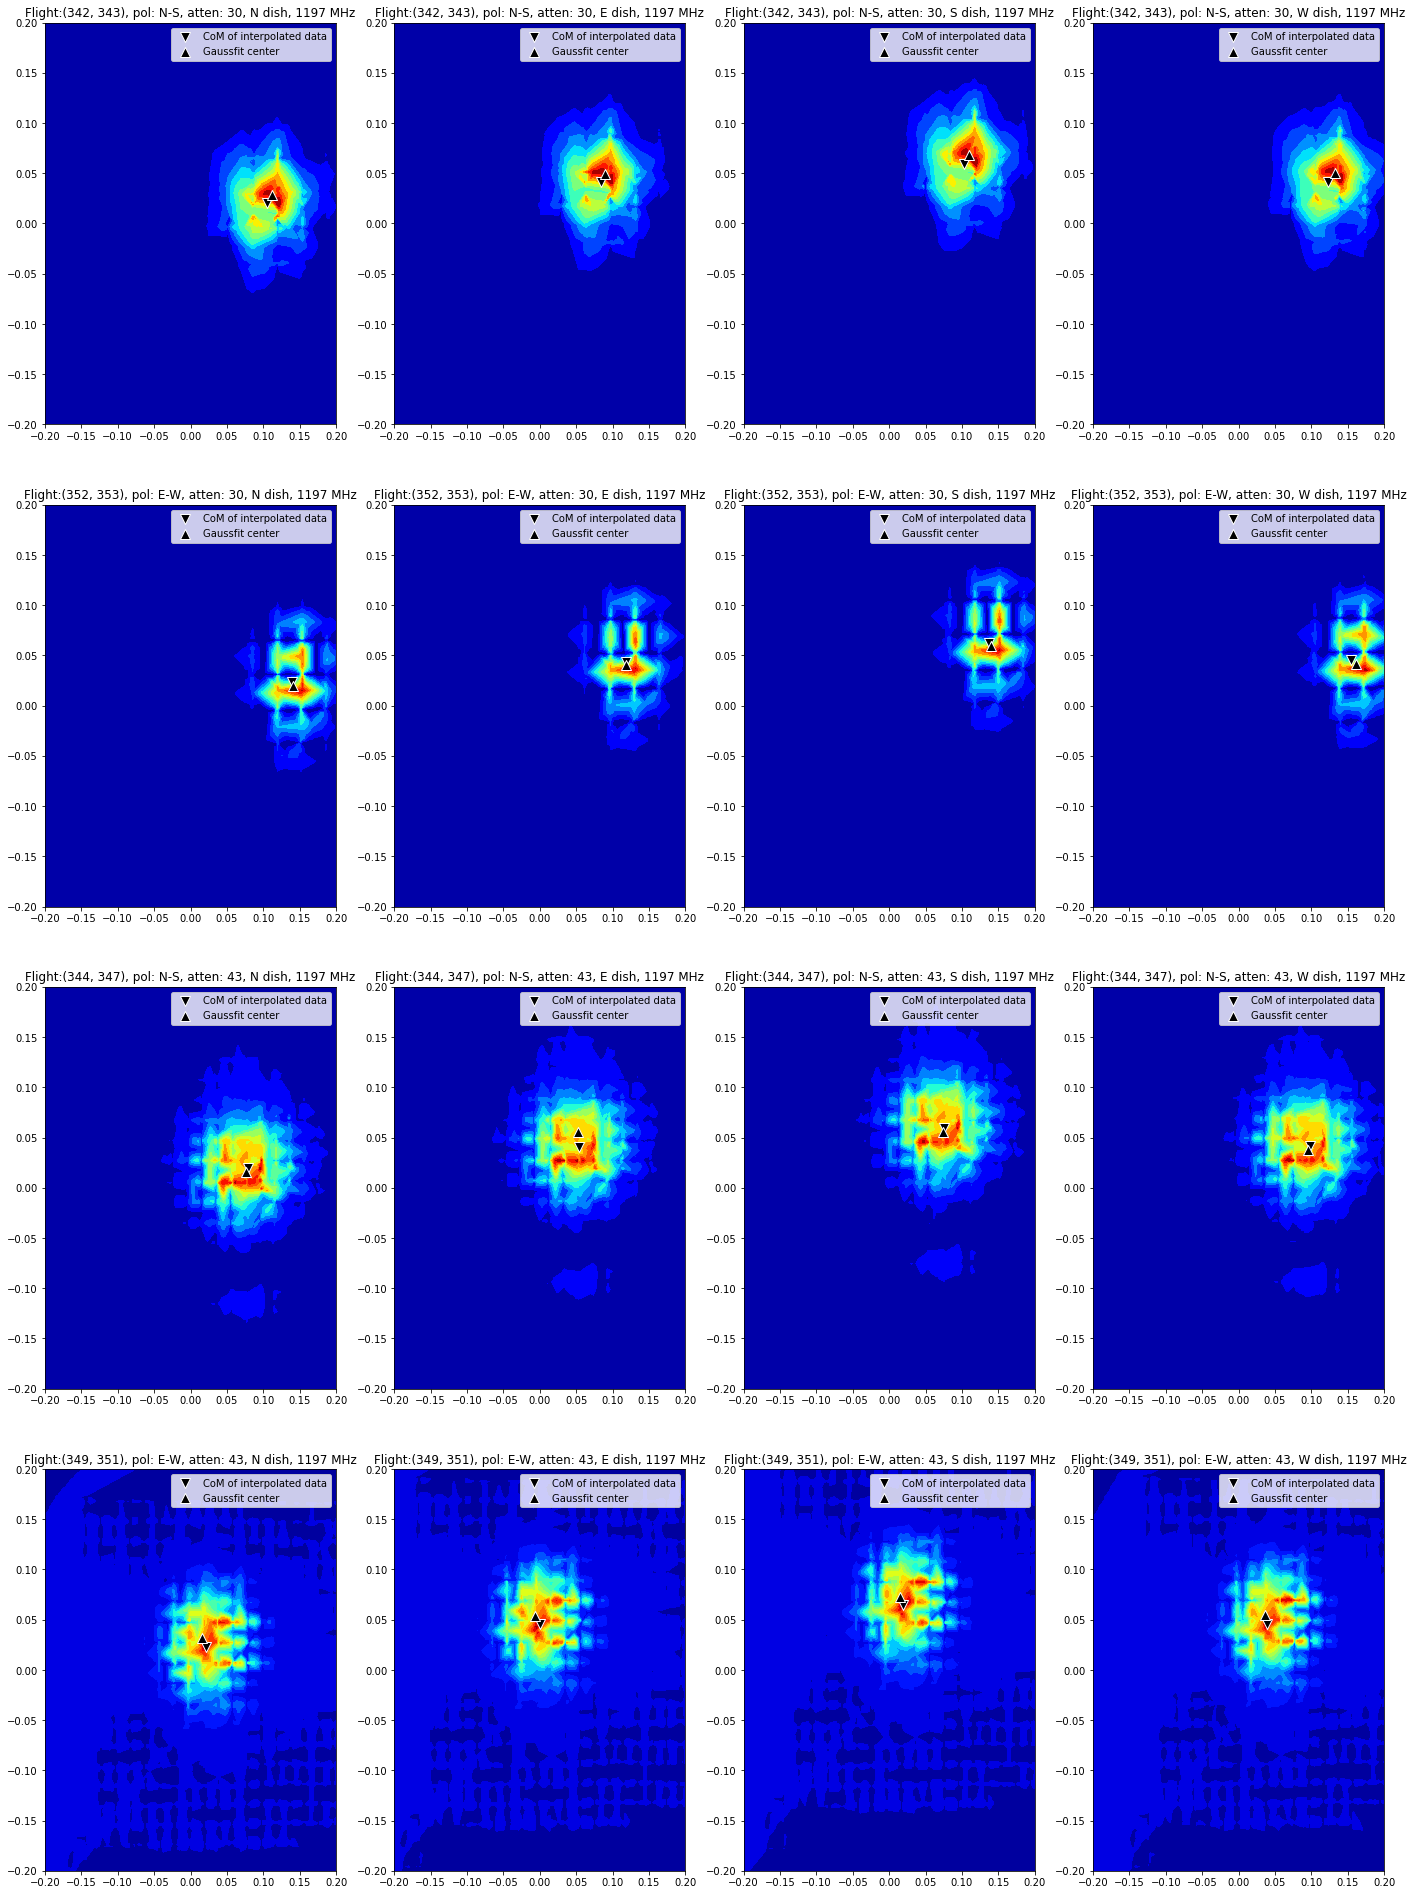

In [26]:
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize = (24,34))
ax11, ax21, ax31, ax41 = axs[0] #first number is dish, 2nd number is flight pair
ax12, ax22, ax32, ax42 = axs[1]
ax13, ax23, ax33, ax43 = axs[2]
ax14, ax24, ax34, ax44 = axs[3]

ax11.contourf(xi, yi, interparray[0], 15, cmap = 'jet')
ax21.contourf(xi, yi, interparray[1], 15, cmap = 'jet')
ax31.contourf(xi, yi, interparray[2], 15, cmap = 'jet')
ax41.contourf(xi, yi, interparray[3], 15, cmap = 'jet')
ax12.contourf(xi, yi, interparray[4], 15, cmap = 'jet')
ax22.contourf(xi, yi, interparray[5], 15, cmap = 'jet')
ax32.contourf(xi, yi, interparray[6], 15, cmap = 'jet')
ax42.contourf(xi, yi, interparray[7], 15, cmap = 'jet')
ax13.contourf(xi, yi, interparray[8], 15, cmap = 'jet')
ax23.contourf(xi, yi, interparray[9], 15, cmap = 'jet')
ax33.contourf(xi, yi, interparray[10], 15, cmap = 'jet')
ax43.contourf(xi, yi, interparray[11], 15, cmap = 'jet')
ax14.contourf(xi, yi, interparray[12], 15, cmap = 'jet')
ax24.contourf(xi, yi, interparray[13], 15, cmap = 'jet')
ax34.contourf(xi, yi, interparray[14], 15, cmap = 'jet')
ax44.contourf(xi, yi, interparray[15], 15, cmap = 'jet')

ax11.scatter(com[0][0], com[0][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax21.scatter(com[1][0], com[1][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax31.scatter(com[2][0], com[2][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax41.scatter(com[3][0], com[3][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax12.scatter(com[4][0], com[4][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax22.scatter(com[5][0], com[5][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax32.scatter(com[6][0], com[6][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax42.scatter(com[7][0], com[7][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax13.scatter(com[8][0], com[8][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax23.scatter(com[9][0], com[9][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax33.scatter(com[10][0], com[10][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax43.scatter(com[11][0], com[11][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax14.scatter(com[12][0], com[12][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax24.scatter(com[13][0], com[13][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax34.scatter(com[14][0], com[14][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')
ax44.scatter(com[15][0], com[15][1], color = 'black', edgecolors = 'white', marker = 'v', s = 100, label = 'CoM of interpolated data')

ax11.scatter(uncert['x0'][0], uncert['y0'][0], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax21.scatter(uncert['x0'][1], uncert['y0'][1], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax31.scatter(uncert['x0'][2], uncert['y0'][2], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax41.scatter(uncert['x0'][3], uncert['y0'][3], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax12.scatter(uncert['x0'][4], uncert['y0'][4], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax22.scatter(uncert['x0'][5], uncert['y0'][5], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax32.scatter(uncert['x0'][6], uncert['y0'][6], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax42.scatter(uncert['x0'][7], uncert['y0'][7], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax13.scatter(uncert['x0'][8], uncert['y0'][8], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax23.scatter(uncert['x0'][9], uncert['y0'][9], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax33.scatter(uncert['x0'][10], uncert['y0'][10], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax43.scatter(uncert['x0'][11], uncert['y0'][11], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax14.scatter(uncert['x0'][12], uncert['y0'][12], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax24.scatter(uncert['x0'][13], uncert['y0'][13], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax34.scatter(uncert['x0'][14], uncert['y0'][14], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')
ax44.scatter(uncert['x0'][15], uncert['y0'][15], color = 'black', edgecolors = 'white', marker = '^', s = 100, label = 'Gaussfit center')

labels = []
for i in range(16):
    labels.append('Flight:('+uncert['flights'][i]+'), pol: '+(uncert['pol'][i])+', atten: '+str(uncert['atten'][i])+', '+uncert['dish'][i]+' dish, '+str(int(np.round(maxfreq)))+' MHz')
ax11.set_title(labels[0])
ax21.set_title(labels[1])
ax31.set_title(labels[2])
ax41.set_title(labels[3])
ax12.set_title(labels[4])
ax22.set_title(labels[5])
ax32.set_title(labels[6])
ax42.set_title(labels[7])
ax13.set_title(labels[8])
ax23.set_title(labels[9])
ax33.set_title(labels[10])
ax43.set_title(labels[11])
ax14.set_title(labels[12])
ax24.set_title(labels[13])
ax34.set_title(labels[14])
ax44.set_title(labels[15])

ax11.legend()
ax21.legend()
ax31.legend()
ax41.legend()
ax12.legend()
ax22.legend()
ax32.legend()
ax42.legend()
ax13.legend()
ax23.legend()
ax33.legend()
ax43.legend()
ax14.legend()
ax24.legend()
ax34.legend()
ax44.legend()


#plt.savefig(str(int(np.round(maxfreq)))+'mhz_allflights.png')

In [66]:
ndishx = np.array(uncert['x0'][np.where(uncert['dish']=='N')])
ndishx = np.append(ndishx, ndishx[0])
ndishy = np.array(uncert['y0'][np.where(uncert['dish']=='N')])
ndishy = np.append(ndishy, ndishy[0])
edishx = np.array(uncert['x0'][np.where(uncert['dish']=='E')])
edishx = np.append(edishx, edishx[0])
edishy = np.array(uncert['y0'][np.where(uncert['dish']=='E')])
edishy = np.append(edishy, edishy[0])
sdishx = np.array(uncert['x0'][np.where(uncert['dish']=='S')])
sdishx = np.append(sdishx, sdishx[0])
sdishy = np.array(uncert['y0'][np.where(uncert['dish']=='S')])
sdishy = np.append(sdishy, sdishy[0])
wdishx = np.array(uncert['x0'][np.where(uncert['dish']=='W')])
wdishx = np.append(wdishx, wdishx[0])
wdishy = np.array(uncert['y0'][np.where(uncert['dish']=='W')])
wdishy = np.append(wdishy, wdishy[0])

flights = []
for i in range(len(uncert['flights'])):
    if uncert['flights'][i] not in flights:
        flights.append(uncert['flights'][i])
flights.append(flights[0])

In [67]:
displacements = Table(names = ('flights', 'N_delta_mag', 'N_delta_theta', 'E_delta_mag', 'E_delta_theta'
                               , 'S_delta_mag', 'S_delta_theta', 'W_delta_mag', 'W_delta_theta')
                     , dtype = ['str', 'float', 'float', 'float', 'float', 'float', 'float', 'float', 'float'])
for i in range(4):
    ndisplace_mag = np.sqrt((ndishx[i]-ndishx[i+1])**2 + (ndishy[i]-ndishy[i+1])**2)
    if (ndishx[i]-ndishx[i+1]) < 0:
        ndisplace_theta = np.arctan((ndishy[i]-ndishy[i+1])/(ndishx[i]-ndishx[i+1]))+np.pi
    else:
        ndisplace_theta = np.arctan((ndishy[i]-ndishy[i+1])/(ndishx[i]-ndishx[i+1]))
        
    edisplace_mag = np.sqrt((edishx[i]-edishx[i+1])**2 + (edishy[i]-edishy[i+1])**2)
    if (edishx[i]-edishx[i+1]) < 0:
        edisplace_theta = np.arctan((edishy[i]-edishy[i+1])/(edishx[i]-edishx[i+1]))+np.pi
    else:
        edisplace_theta = np.arctan((edishy[i]-edishy[i+1])/(edishx[i]-edishx[i+1]))
    
    sdisplace_mag = np.sqrt((sdishx[i]-sdishx[i+1])**2 + (sdishy[i]-sdishy[i+1])**2)
    if (sdishx[i]-sdishx[i+1]) < 0:
        sdisplace_theta = np.arctan((sdishy[i]-sdishy[i+1])/(sdishx[i]-sdishx[i+1]))+np.pi
    else:
        sdisplace_theta = np.arctan((sdishy[i]-sdishy[i+1])/(sdishx[i]-sdishx[i+1]))
        
    wdisplace_mag = np.sqrt((wdishx[i]-wdishx[i+1])**2 + (wdishy[i]-wdishy[i+1])**2)
    if (wdishx[i]-wdishx[i+1]) < 0:
        wdisplace_theta = np.arctan((wdishy[i]-wdishy[i+1])/(wdishx[i]-wdishx[i+1]))+np.pi
    else:
        wdisplace_theta = np.arctan((wdishy[i]-wdishy[i+1])/(wdishx[i]-wdishx[i+1]))
        
    nextrow = ('('+flights[i]+') to ('+flights[i+1]+')', ndisplace_mag, ndisplace_theta, edisplace_mag, edisplace_theta
              , sdisplace_mag, sdisplace_theta, wdisplace_mag, wdisplace_theta)
    displacements.add_row(nextrow)



In [86]:
displacements

<Table length=4>
        flights              N_delta_mag      ...    W_delta_theta    
         str24                 float64        ...       float64       
------------------------ -------------------- ... --------------------
(342, 343) to (352, 353) 0.030198637727984333 ...   2.8591321053143943
(352, 353) to (344, 347)   0.0658360469474141 ... 0.060209450791388876
(344, 347) to (349, 351)  0.06149599753804517 ...  -0.2734792273951427
(349, 351) to (342, 343)  0.09603913218199837 ...     3.09675209482687

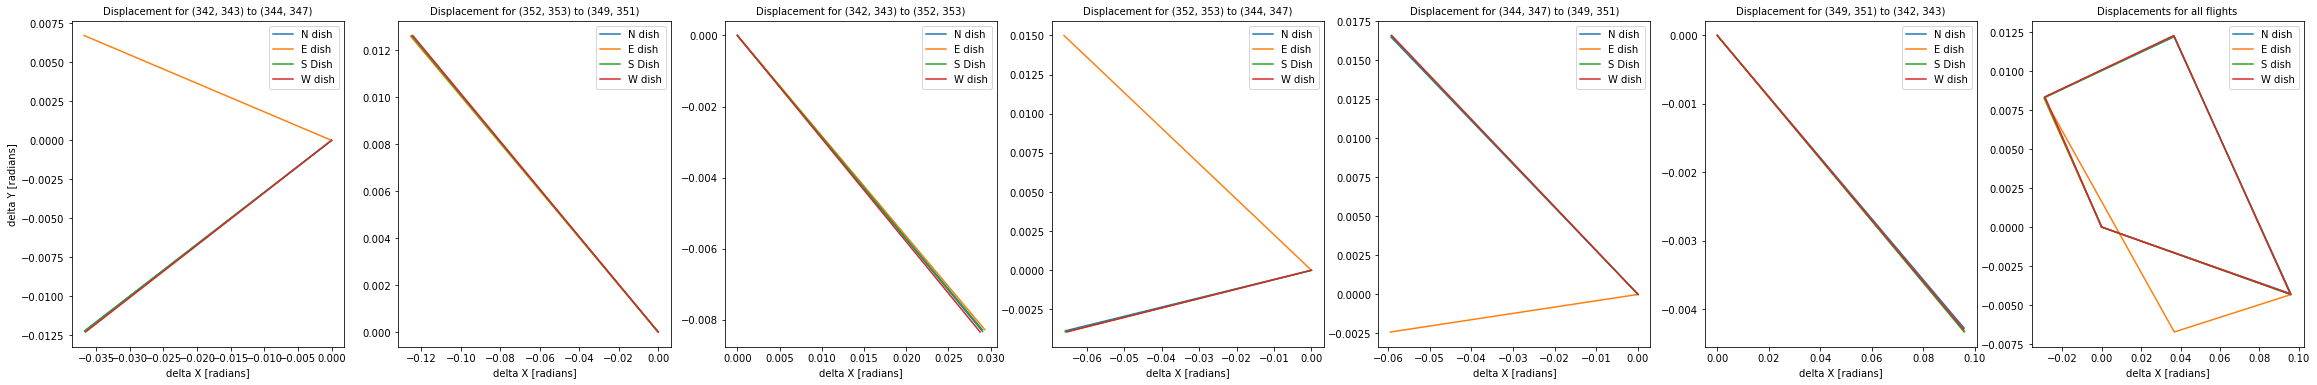

In [78]:
fig, axs = plt.subplots(nrows = 1, ncols = 7, figsize = (40,6))
ax_1, ax0, ax1, ax2, ax3, ax4, ax5 = axs

ax_1.plot([0, ndishx[2]-ndishx[0]], [0, ndishy[2]-ndishy[0]], label = 'N dish')
ax_1.plot([0, edishx[2]-edishx[0]], [0, edishy[2]-edishy[0]], label = 'E dish')
ax_1.plot([0, sdishx[2]-sdishx[0]], [0, sdishy[2]-sdishy[0]], label = 'S Dish')
ax_1.plot([0, wdishx[2]-wdishx[0]], [0, wdishy[2]-wdishy[0]], label = 'W dish')
ax_1.legend()
ax_1.set_title('Displacement for ('+flights[0]+') to ('+flights[2]+')', fontsize = 10)
ax_1.set_xlabel('delta X [radians]')
ax_1.set_ylabel('delta Y [radians]')

ax0.plot([0, ndishx[3]-ndishx[1]], [0, ndishy[3]-ndishy[1]], label = 'N dish')
ax0.plot([0, edishx[3]-edishx[1]], [0, edishy[3]-edishy[1]], label = 'E dish')
ax0.plot([0, sdishx[3]-sdishx[1]], [0, sdishy[3]-sdishy[1]], label = 'S Dish')
ax0.plot([0, wdishx[3]-wdishx[1]], [0, wdishy[3]-wdishy[1]], label = 'W dish')
ax0.legend()
ax0.set_title('Displacement for ('+flights[1]+') to ('+flights[3]+')', fontsize = 10)
ax0.set_xlabel('delta X [radians]')

ax1.plot([0, ndishx[1]-ndishx[0]], [0, ndishy[1]-ndishy[0]], label = 'N dish')
ax1.plot([0, edishx[1]-edishx[0]], [0, edishy[1]-edishy[0]], label = 'E dish')
ax1.plot([0, sdishx[1]-sdishx[0]], [0, sdishy[1]-sdishy[0]], label = 'S Dish')
ax1.plot([0, wdishx[1]-wdishx[0]], [0, wdishy[1]-wdishy[0]], label = 'W dish')
ax1.legend()
ax1.set_title('Displacement for ('+flights[0]+') to ('+flights[1]+')', fontsize = 10)
ax1.set_xlabel('delta X [radians]')

ax2.plot([0, ndishx[2]-ndishx[1]], [0, ndishy[2]-ndishy[1]], label = 'N dish')
ax2.plot([0, edishx[2]-edishx[1]], [0, edishy[2]-edishy[1]], label = 'E dish')
ax2.plot([0, sdishx[2]-sdishx[1]], [0, sdishy[2]-sdishy[1]], label = 'S Dish')
ax2.plot([0, wdishx[2]-wdishx[1]], [0, wdishy[2]-wdishy[1]], label = 'W dish')
ax2.legend()
ax2.set_title('Displacement for ('+flights[1]+') to ('+flights[2]+')', fontsize = 10)
ax2.set_xlabel('delta X [radians]')

ax3.plot([0, ndishx[3]-ndishx[2]], [0, ndishy[3]-ndishy[2]], label = 'N dish')
ax3.plot([0, edishx[3]-edishx[2]], [0, edishy[3]-edishy[2]], label = 'E dish')
ax3.plot([0, sdishx[3]-sdishx[2]], [0, sdishy[3]-sdishy[2]], label = 'S Dish')
ax3.plot([0, wdishx[3]-wdishx[2]], [0, wdishy[3]-wdishy[2]], label = 'W dish')
ax3.legend()
ax3.set_title('Displacement for ('+flights[2]+') to ('+flights[3]+')', fontsize = 10)
ax3.set_xlabel('delta X [radians]')


ax4.plot([0, ndishx[4]-ndishx[3]], [0, ndishy[4]-ndishy[3]], label = 'N dish')
ax4.plot([0, edishx[4]-edishx[3]], [0, edishy[4]-edishy[3]], label = 'E dish')
ax4.plot([0, sdishx[4]-sdishx[3]], [0, sdishy[4]-sdishy[3]], label = 'S Dish')
ax4.plot([0, wdishx[4]-wdishx[3]], [0, wdishy[4]-wdishy[3]], label = 'W dish')
ax4.legend()
ax4.set_title('Displacement for ('+flights[3]+') to ('+flights[0]+')', fontsize = 10 )
ax4.set_xlabel('delta X [radians]')


ax5.plot(ndishx[0]-ndishx, ndishy[0]-ndishy, label = 'N dish')
ax5.plot(edishx[0]-edishx, edishy[0]-edishy, label = 'E dish')
ax5.plot(sdishx[0]-sdishx, sdishy[0]-sdishy, label = 'S dish')
ax5.plot(wdishx[0]-wdishx, wdishy[0]-wdishy, label = 'W dish')
ax5.legend()
ax5.set_xlabel('delta X [radians]')
ax5.set_title('Displacements for all flights', fontsize = 10)

plt.savefig('../Data/1197Mhz_Displacements.png')

In [87]:
allFLYs

[{'FLY': '340',
  'y': array([4538706.36488649, 4538706.36488649, 4538706.36488649, ...,
         4538701.54525549, 4538701.54747652, 4538701.54747652]),
  'autos': [array([[2.8867263e+12, 3.9837908e+12, 9.0201423e+12, ..., 3.2483128e+11,
           3.2514304e+11, 4.8268549e+11],
          [2.7026632e+12, 3.9230993e+12, 8.6723757e+12, ..., 3.2173792e+11,
           3.2251711e+11, 4.8843093e+11],
          [5.5181878e+12, 4.0950256e+12, 8.8007005e+12, ..., 3.2725923e+11,
           3.2625951e+11, 4.9157308e+11],
          ...,
          [2.6899471e+12, 3.5354300e+12, 7.8948362e+12, ..., 3.1933025e+11,
           3.2063377e+11, 4.3718594e+11],
          [2.5947448e+12, 3.5445612e+12, 7.8336408e+12, ..., 3.1911929e+11,
           3.1913869e+11, 4.3701617e+11],
          [2.6621476e+12, 3.5389988e+12, 7.8655872e+12, ..., 3.1729304e+11,
           3.1810231e+11, 4.3688405e+11]], dtype=float32),
   array([[1.1851701e+13, 1.7175106e+13, 2.8201938e+13, ..., 3.1507356e+11,
           3.1650978e